# ARIMAX Test Inference

Notebook dùng để load các mô hình ARIMAX (.pkl) đã huấn luyện và đánh giá trực tiếp trên toàn bộ tập test (không rolling horizon). Mục tiêu: chạy dự đoán một lượt, đo thời gian và tính các metric (MAE, RMSE, MAPE, R²) kèm biểu đồ trực quan cho từng target.


In [1]:
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model_utils import (
    load_model,
    get_latest_model,
    calculate_metrics,
    print_metrics,
)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f"{x:,.6f}")

print("✓ Libraries imported")


✓ Libraries imported


In [2]:
# Paths & targets
MODELS_DIR = Path('models')
DATA_DIR = Path('processed_data')
TARGETS = ['memory_usage_pct', 'cpu_total_usage', 'system_load']

MODELS_DIR.mkdir(exist_ok=True)

print("Configuration ready")


Configuration ready


In [3]:
def load_test_data(target: str):
    target_dir = DATA_DIR / target
    X_test = pd.read_csv(target_dir / 'X_test.csv')
    y_test = pd.read_csv(target_dir / 'y_test.csv').squeeze()
    return X_test, y_test


def resolve_model_paths(model_name: str = 'arimax'):
    model_paths = {}
    for target in TARGETS:
        model_paths[target] = get_latest_model(
            models_dir=str(MODELS_DIR),
            model_name=model_name,
            target=target,
        )
    return model_paths


model_paths = resolve_model_paths()
model_paths


Latest model: models\arimax_memory_usage_pct_20251111_154333.pkl
Latest model: models\arimax_cpu_total_usage_20251111_154831.pkl
Latest model: models\arimax_system_load_20251111_155022.pkl


{'memory_usage_pct': 'models\\arimax_memory_usage_pct_20251111_154333.pkl',
 'cpu_total_usage': 'models\\arimax_cpu_total_usage_20251111_154831.pkl',
 'system_load': 'models\\arimax_system_load_20251111_155022.pkl'}

In [4]:
evaluation_records = []
detailed_results = {}
prediction_store = {}
evaluation_results = {}

for target in TARGETS:
    print("\n" + "=" * 80)
    print(f"Target: {target}")
    print("=" * 80)

    X_test, y_test = load_test_data(target)
    model_path = model_paths[target]
    model, metadata = load_model(model_path)

    start_time = time.time()
    y_pred = model.forecast(steps=len(y_test), exog=X_test)
    runtime = time.time() - start_time
    per_sample_ms = runtime / len(y_test) * 1000

    y_pred = np.asarray(y_pred)

    metrics = calculate_metrics(y_test.values, y_pred)
    print_metrics(metrics, target)
    print(f"  Runtime: {runtime:.2f}s ({per_sample_ms:.3f} ms/sample)")

    evaluation_records.append({
        'target': target,
        'model_path': model_path,
        'samples': len(y_test),
        'runtime_s': runtime,
        'ms_per_sample': per_sample_ms,
        **metrics,
    })

    detailed_results[target] = {
        'model_path': model_path,
        'metadata': metadata,
        'samples': len(y_test),
        'runtime_seconds': runtime,
        'ms_per_sample': per_sample_ms,
        'metrics': metrics,
    }

    prediction_store[target] = {
        'y_true': y_test.values,
        'y_pred': y_pred,
    }

    evaluation_results[target] = metrics

print("\n✓ Evaluation finished")



Target: memory_usage_pct
✓ Model loaded: models\arimax_memory_usage_pct_20251111_154333.pkl
  Model: arimax
  Target: memory_usage_pct
  Saved at: 2025-11-11 15:43:33

Metrics for memory_usage_pct:
  MAE:         3.734215
  RMSE:        4.218339
  MAPE:        911.84%
  R²:          -21.727432
  Max Error:   7.118625
  Median AE:   3.863028
  Runtime: 0.89s (0.052 ms/sample)

Target: cpu_total_usage
✓ Model loaded: models\arimax_cpu_total_usage_20251111_154831.pkl
  Model: arimax
  Target: cpu_total_usage
  Saved at: 2025-11-11 15:48:31

Metrics for cpu_total_usage:
  MAE:         0.301637
  RMSE:        0.794691
  MAPE:        105.07%
  R²:          0.339684
  Max Error:   20.587866
  Median AE:   0.151985
  Runtime: 0.78s (0.046 ms/sample)

Target: system_load
✓ Model loaded: models\arimax_system_load_20251111_155022.pkl
  Model: arimax
  Target: system_load
  Saved at: 2025-11-11 15:50:22

Metrics for system_load:
  MAE:         1.380341
  RMSE:        1.792193
  MAPE:        2399.

In [5]:
summary_df = pd.DataFrame(evaluation_records).set_index('target')
summary_df


,model_path,samples,runtime_s,ms_per_sample,mae,rmse,mse,mape,r2,max_error,median_ae
target,,,,,,,,,,,
memory_usage_pct,models\arimax_memory_usage_pct_20251111_154333...,17150,0.885996,0.051662,3.734215,4.218339,17.794386,911.840416,-21.727432,7.118625,3.863028
cpu_total_usage,models\arimax_cpu_total_usage_20251111_154831.pkl,17150,0.783998,0.045714,0.301637,0.794691,0.631534,105.067131,0.339684,20.587866,0.151985
system_load,models\arimax_system_load_20251111_155022.pkl,17150,0.817008,0.047639,1.380341,1.792193,3.211954,"2,399.639228",-2.349771,11.749536,1.268681


## Visualization


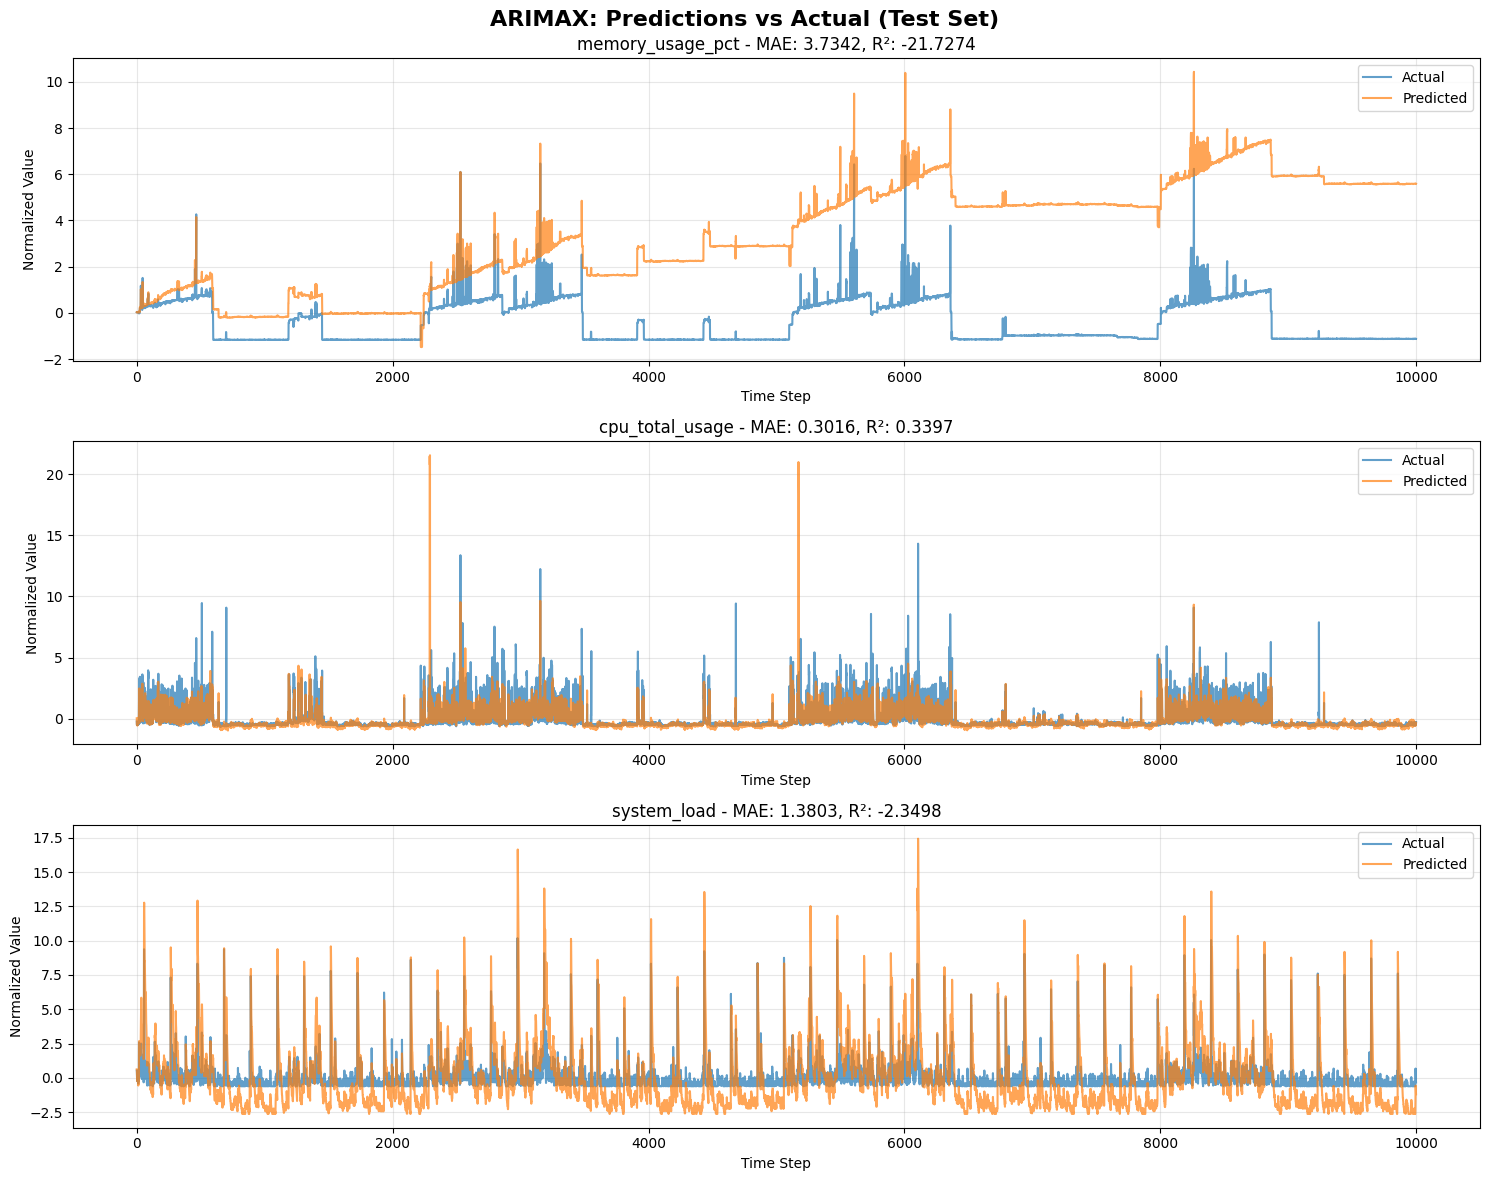

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('ARIMAX: Predictions vs Actual (Test Set)', fontsize=16, fontweight='bold')

for idx, target in enumerate(TARGETS):
    if target not in prediction_store:
        axes[idx].set_visible(False)
        continue

    y_true = prediction_store[target]['y_true']
    y_pred = prediction_store[target]['y_pred']

    n_plot = min(10000, len(y_true))
    axes[idx].plot(y_true[:n_plot], label='Actual', alpha=0.7, linewidth=1.5)
    axes[idx].plot(y_pred[:n_plot], label='Predicted', alpha=0.7, linewidth=1.5)
    axes[idx].set_title(
        f"{target} - MAE: {evaluation_results[target]['mae']:.4f}, "
        f"R²: {evaluation_results[target]['r2']:.4f}"
    )
    axes[idx].set_xlabel('Time Step')
    axes[idx].set_ylabel('Normalized Value')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


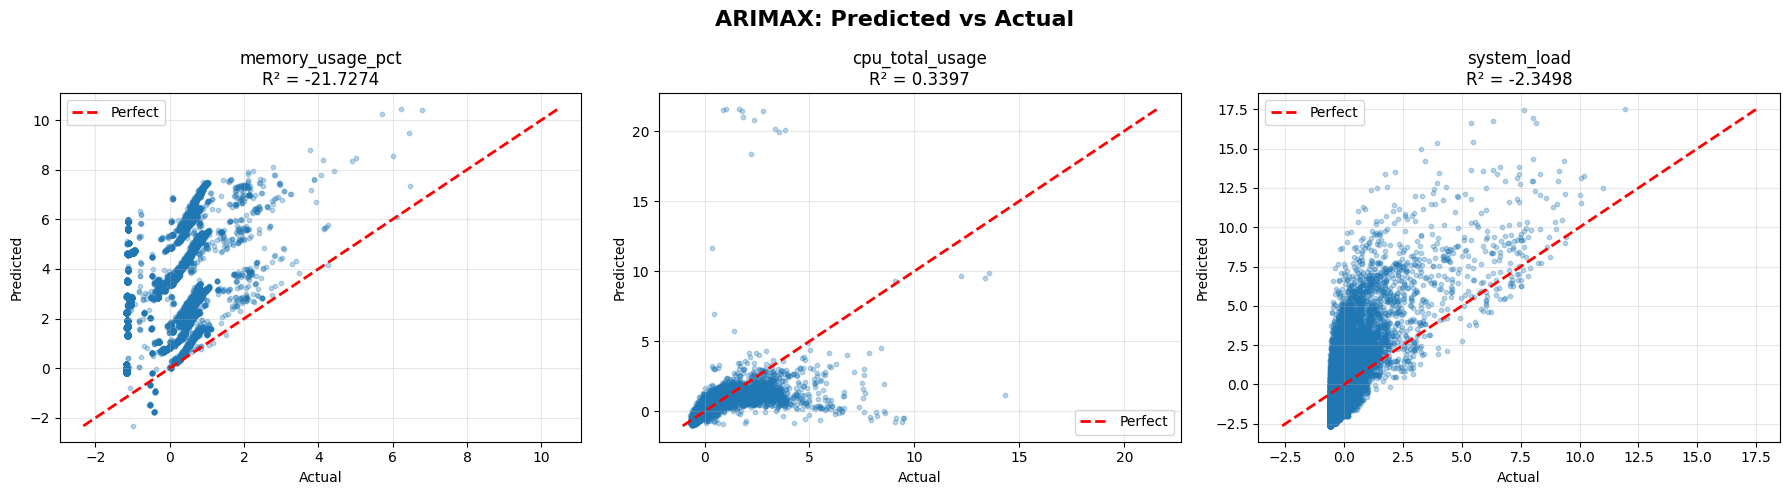

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('ARIMAX: Predicted vs Actual', fontsize=16, fontweight='bold')

for idx, target in enumerate(TARGETS):
    if target not in prediction_store:
        axes[idx].set_visible(False)
        continue

    y_true = prediction_store[target]['y_true']
    y_pred = prediction_store[target]['y_pred']

    axes[idx].scatter(y_true, y_pred, alpha=0.3, s=10)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')

    axes[idx].set_title(f"{target}\nR² = {evaluation_results[target]['r2']:.4f}")
    axes[idx].set_xlabel('Actual')
    axes[idx].set_ylabel('Predicted')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


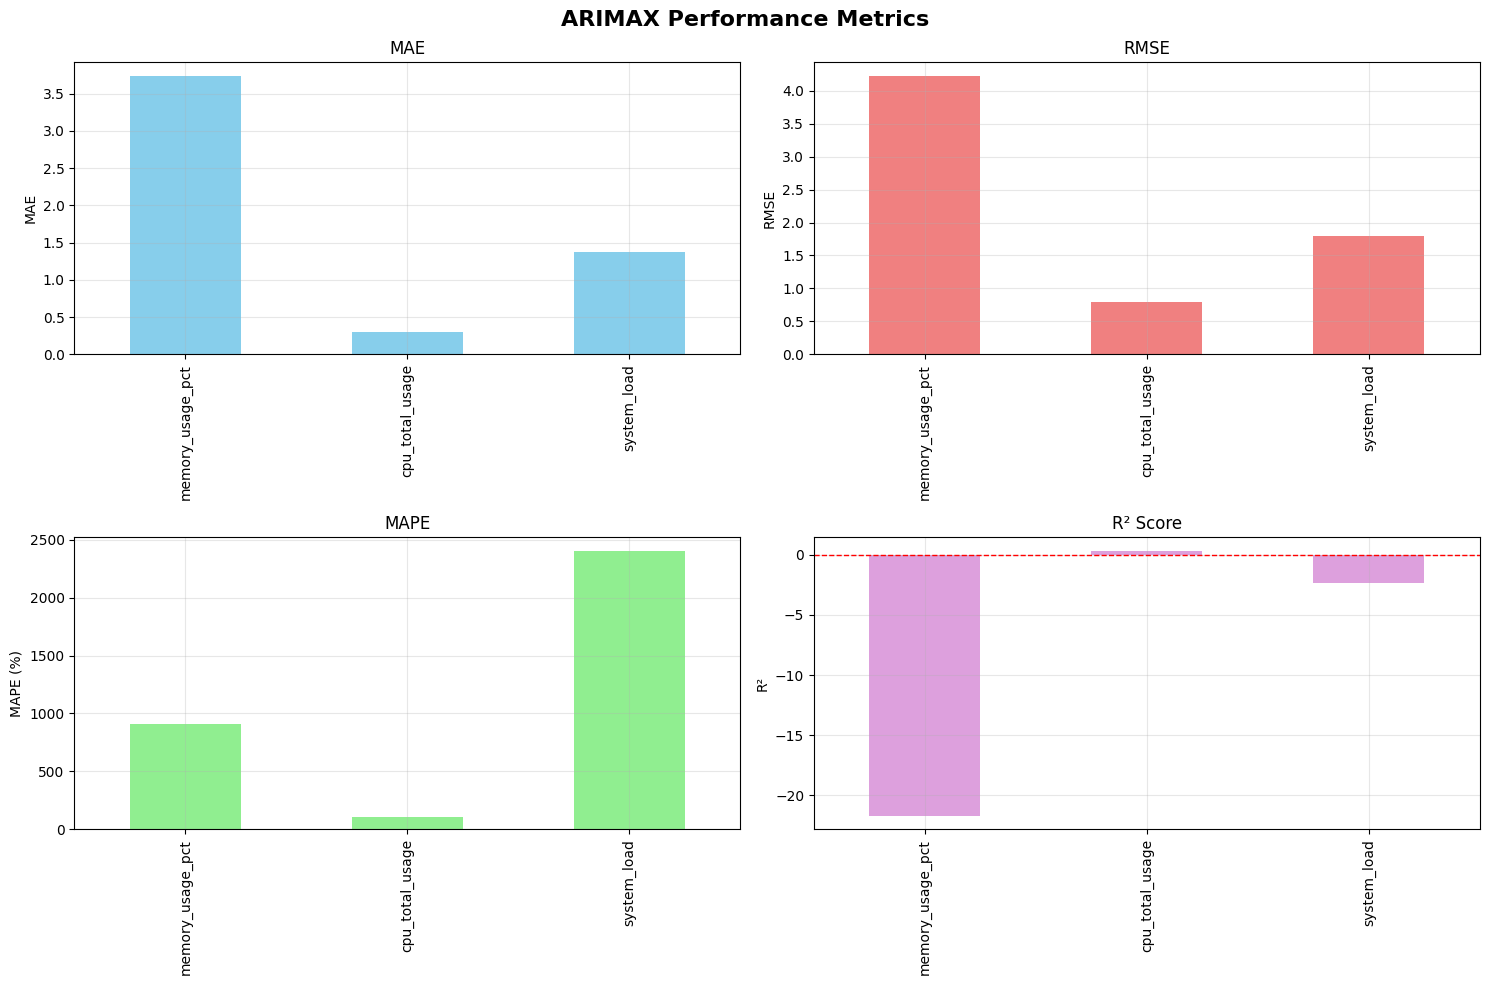

In [8]:
metrics_df = pd.DataFrame(evaluation_results).T

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ARIMAX Performance Metrics', fontsize=16, fontweight='bold')

metrics_df['mae'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('MAE')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True, alpha=0.3)

metrics_df['rmse'].plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('RMSE')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].grid(True, alpha=0.3)

metrics_df['mape'].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('MAPE')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)

metrics_df['r2'].plot(kind='bar', ax=axes[1, 1], color='plum')
axes[1, 1].set_title('R² Score')
axes[1, 1].set_ylabel('R²')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
# (Optional) lưu nhanh kết quả sang JSON
from model_utils import save_results

results_payload = {
    'model': 'arimax',
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'targets': detailed_results,
}

save_results(results_payload, 'results_arimax_inference_test.json')


✓ Results saved: results_arimax_inference_test.json


'results_arimax_inference_test.json'